Notebook for Optim application. Notebook for supplementary material of a submitted publication. 

### Imports and settings

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json


%matplotlib widget
import time
import numpy as np
from aeromaps import create_process
from aeromaps.core.models import (
    models_optim_complex,
)


import gemseo as gm
gm.configure_logger()

<RootLogger root (INFO)>

# 1- Scenario initialisation and settings

The first phase corresponds to running a first, central scenario with AeroMAPS. Other runs ar performed afterwards.

In [2]:
from aeromaps.utils.functions import create_partitioning

In [3]:
create_partitioning(file="data_optim/aeroscope_europe_data.csv", path="data_optim")

## 2. Run AeroMAPS on this studied scope

In [4]:
%matplotlib widget
from aeromaps import create_process
from aeromaps.core.models import default_models_top_down

In [5]:
models = {
    "models_optim_complex": models_optim_complex,
}
models['models_optim_complex']['default_models_top_down']['models_traffic'].pop('rpk')
models['models_optim_complex']['default_models_top_down']['models_operation_cost_top_down'].pop('passenger_aircraft_total_cost_and_airfare')


Create process as usual, the partitionning is recuperated as specified in the config file.

In [6]:
process = create_process(
    configuration_file="data_optim/config.json",
    models=models,
    use_fleet_model=False
)

## 1-a) Air traffic evolution

As of April 2024, AeroMAPS is considering an exgenous growth rate.
For the purposes of this article, an uniform growth rate of 3% is set. This is significantly lower from industry prospects such as [Airbus GMF: 3.6%](https://www.airbus.com/en/products-services/commercial-aircraft/market/global-market-forecast) or [Boeing CMO: 3.8%](https://www.boeing.com/content/dam/boeing/boeingdotcom/market/assets/downloads/CMO_2022_Report_FINAL_v02.pdf), but higher than [IEA Net Zero: 2.1% (2019 as base year)](https://www.iea.org/reports/net-zero-roadmap-a-global-pathway-to-keep-the-15-0c-goal-in-reach).


In [7]:
## Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [1.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [1.0]
process.parameters.reference_cagr_aviation_reference_periods= []
process.parameters.reference_cagr_aviation_reference_periods_values= [1.0]

## 1-b) Aircraft fleet

Top-down fleet, without hydrogen aircraft, callibrated on the fleet of the MACC applciation, with drop-in instead of h2  
http://localhost:8888/lab/tree/aeromaps/notebooks/data_cost/top_down_cost_callibration_phd.ipynb

Mean annual efficiency improvement: 1.4% --> applied to all catgeories

In [8]:
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years_values = [1.4]

## Hydrogen aircraft
# NONE

### 1-c) Operational improvements

Operational improvements are considered via two opportunities. 
- Load factor improvement: improvement to 89% at the end of the scenario.
- Operational efficiency (better ATM, aircrfat MRO and operational optimisation): improvement of 8% in 25y. 

Cost savings incur through the fuel savings. However, it could come at an extra cost (non-energy). This parameter is modelled, but not considered in this article due to lack of specific informations to the best of our knowldege.


In [9]:
process.parameters.load_factor_end_year = 89.0  # 2019 value: 82.399312

In [10]:
# Aircraft fleet and operation evolution - Operations

## Values for setting the logistic function
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

## 1-d) Energy

Top-down callibrated on the values of teh MACC apllication.
Faster optim but caution as MFSP full computation is more detailled: larges use of e-fuel in the begining influence late mFSp (no-decomissioning)

In [11]:
# # Energy settings: production choices

# # Aircraft energy - Introduction of alternative drop-in fuels

# ## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.biofuel_share_reference_years_values = np.array([4.8, 15, 24, 27, 35])
process.parameters.electrofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.electrofuel_share_reference_years_values = np.array([1.2, 5, 10, 15, 35])


## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
process.parameters.biofuel_hefa_fog_share_reference_years = []
process.parameters.biofuel_hefa_fog_share_reference_years_values = [0.6]
process.parameters.biofuel_hefa_others_share_reference_years = []
process.parameters.biofuel_hefa_others_share_reference_years_values = [12.5]
process.parameters.biofuel_ft_others_share_reference_years = []
process.parameters.biofuel_ft_others_share_reference_years_values = [68.9]
process.parameters.biofuel_ft_msw_share_reference_years = []
process.parameters.biofuel_ft_msw_share_reference_years_values = [6.6]


In [12]:
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years_values = [0.815488]
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years_values = [1.052703]
process.parameters.biofuel_ft_others_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_others_mfsp_simple_reference_years_values = [1.378082]
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years_values = [1.142423]
process.parameters.biofuel_atj_mfsp_simple_reference_years = []
process.parameters.biofuel_atj_mfsp_simple_reference_years_values = [1.38668]

process.parameters.electrofuel_mfsp_simple_reference_years = [
    2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
    2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
    2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050
]
process.parameters.electrofuel_mfsp_simple_reference_years_values = [
    3.720546, 3.720546, 3.720546, 3.720546, 3.720546, 3.720546, 3.720546,
    3.573659, 3.426978, 3.277308, 3.130003, 3.095717, 3.062247, 3.029682,
    2.998903, 2.971869, 2.946851, 2.923276, 2.901135, 2.882374, 2.866464,
    2.852876, 2.841350, 2.829845, 2.807006, 2.774737, 2.737160, 2.698305,
    2.660365, 2.624329, 2.590476
]

# Enerdata scenario europe-specific data (https://eneroutlook.enerdata.net/forecast-world-co2-intensity-of-electricity-generation.html)
process.parameters.electricity_emission_factor_reference_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
process.parameters.electricity_emission_factor_reference_years_values = [205, 175, 92, 47, 31, 19, 12]

# Optimisation parameters
europe_ask_share = 15.49 / 100

process.parameters.aviation_carbon_budget_objective = 2.6 * europe_ask_share # --> sensitivity 4.8

process.parameters.biomass_availability_constraint_trajectory_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biomass_availability_constraint_trajectory_reference_years_values = [62.8 * europe_ask_share, 72.1 * europe_ask_share, 97.8 * europe_ask_share, 101.8 * europe_ask_share]

process.parameters.electricity_availability_constraint_trajectory_reference_years = [2020, 2030, 2040, 2050]
process.parameters.electricity_availability_constraint_trajectory_reference_years_values = [102.0456 * europe_ask_share, 137.5452 * europe_ask_share, 212.7996 * europe_ask_share, 276.6168 * europe_ask_share]

process.parameters.volume_ramp_up_constraint_biofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_biofuel = 0.2

process.parameters.volume_ramp_up_constraint_electrofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_electrofuel = 0.2


## 1-e) Other process.parameters 

Downscaling not automatic

In [13]:
# Environmental limits

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process.parameters.net_carbon_budget = 850.0
process.parameters.carbon_dioxyde_removal_2100 = 285.0

In [14]:
# Allocation settings

## Aviation share of the global (equivalent) carbon budget [%]
process.parameters.aviation_carbon_budget_allocated_share = 2.6
process.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process.parameters.aviation_biomass_allocated_share = 9.90
process.parameters.aviation_electricity_allocated_share = 5.0

In [15]:
process.parameters.price_elasticity = -0.9

In [16]:
magic_method_view=[]
magic_rpk=[]

import pandas as pd
magic_method_view.append(0.09244362820138416)


# process.parameters.airfare_per_rpk=pd.Series(0.092949239, index=range(2000,2051))

                         
# process.setup()
# process.compute()
# process.parameters.airfare_per_rpk.loc[2025:2050]=process.vector_outputs_df['airfare_per_rpk'].loc[2025:2050]
# # magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# # magic_rpk.append(process.vector_outputs_df['rpk_no_elasticity'].loc[2050])
# # magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

# process.setup()
# process.compute()
# process.parameters.airfare_per_rpk.loc[2025:2050]=process.vector_outputs_df['airfare_per_rpk'].loc[2025:2050]
# magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

# process.setup()
# process.compute()
# process.parameters.airfare_per_rpk.loc[2025:2050]=process.vector_outputs_df['airfare_per_rpk'].loc[2025:2050]
# magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

# process.setup()
# process.compute()
# process.parameters.airfare_per_rpk.loc[2025:2050]=process.vector_outputs_df['airfare_per_rpk'].loc[2025:2050]
# magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

# process.setup()
# process.compute()
# process.parameters.airfare_per_rpk.loc[2025:2050]=process.vector_outputs_df['airfare_per_rpk'].loc[2025:2050]
# magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

# process.setup()
# process.compute()
# process.parameters.airfare_per_rpk.loc[2025:2050]=process.vector_outputs_df['airfare_per_rpk'].loc[2025:2050]
# magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

# process.setup()
# process.compute()
# process.parameters.airfare_per_rpk.loc[2025:2050]=process.vector_outputs_df['airfare_per_rpk'].loc[2025:2050]
# magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

# process.setup()
# process.compute()
# process.parameters.airfare_per_rpk.loc[2025:2050]=process.vector_outputs_df['airfare_per_rpk'].loc[2025:2050]
# magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

# process.setup()
# process.compute()
# process.parameters.airfare_per_rpk.loc[2025:2050]=process.vector_outputs_df['airfare_per_rpk'].loc[2025:2050]
# magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

# process.setup()
# process.compute()
# magic_method_view.append(process.vector_outputs_df['airfare_per_rpk'].loc[2050])
# magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])


In [17]:
# process.plot('air_transport_co2_emissions')

## 2 - Problem definition

### Cas 1 

min cumulative_total_airline_cost_discounted

w.r.t. biofuel_share_reference_years_values, electrofuel_share_reference_years_values, 

s.t. cumulative_co2_emissions, electricity_consumption, biomass_consumption, max(biofuel_share_prospective + electrofuel_share_prospective)



In [18]:
from gemseo.algos.design_space import DesignSpace
from gemseo import generate_n2_plot, create_scenario



design_space = DesignSpace()

process.parameters.airfare_per_rpk=pd.Series(0.09244362820138416, index=range(2000,2051))

process.setup()


# design_space.add_variable("electrofuel_share_reference_years_values", size=6, lower_bound=[0, 0, 0, 0, 0, 0], upper_bound=[100, 100,100, 100, 100, 100], value=[0, 1.2, 5, 10, 15, 35])
# design_space.add_variable("biofuel_share_reference_years_values", size=6, lower_bound=[0, 0, 0, 0, 0, 0], upper_bound=[100, 100,100, 100, 100, 100], value=[2, 4.8, 15, 24, 27, 35])


design_space.add_variable("electrofuel_share_reference_years_values",
                          size=5,
                          lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17], 
                          upper_bound=[100,100, 100, 100, 100],
                          value= [1.53876061e-02, 6.69531291e-02, 1.84765061e+00, 8.85047992e+00,
        1.57302626e+01]
                         )
design_space.add_variable("biofuel_share_reference_years_values",
                          size=5, lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17], 
                          upper_bound=[100,100, 100, 100, 100],
                          value=  [11.02945021, 22.64991278, 45.09265767, 50.79100536, 53.35073021]
                         )


#                   value=[ 2.95630584, 12.01966251, 24.51769195, 45.09794791, 50.85012186,
        # 53.05347661]

objective_name = "cumulative_total_airline_cost_discounted_obj"


process.gemseo_settings["design_space"] = design_space

process.gemseo_settings["objective_name"] = objective_name

# process.gemseo_settings["scenario_type"]="DOE"
process.gemseo_settings["scenario_type"] = "MDO"

# Create a GEMSEO scenario
process.create_gemseo_scenario()

# Set differention method (only use for gradient based optimizers)
process.scenario.set_differentiation_method("finite_differences")

# Add constraints
all_constraints = [
    "aviation_carbon_budget_constraint",
    "blend_completeness_constraint",
    "electricity_trajectory_constraint",
    "biomass_trajectory_constraint",
    "electrofuel_use_growth_constraint",
    "biofuel_use_growth_constraint",
    "biofuel_use_no_degrowth_constraint",
    "electrofuel_use_no_degrowth_constraint"
]


for constraint in all_constraints:
    process.scenario.add_constraint(constraint, constraint_type="ineq")


process.scenario.formulation.optimization_problem.objective = process.scenario.formulation.optimization_problem.objective * 1e-12

##### Base MDO -> in source for DOE [...]

# Configure the algorithm used
algo_options = {
    "ftol_rel": 0.001,
    "ctol_abs": 0.001,
    "ftol_abs": 0.001,
    "normalize_design_space": True,
    "init_step": 0.8
}
process.scenario.options = {
    "algo": "NLOPT_COBYLA",
    "max_iter": 200,
    "algo_options": algo_options
}

 WARNING - 16:11:25: No coupling in MDA, switching chain_linearize to True.


In [19]:
process.compute()

    INFO - 16:11:25:  
    INFO - 16:11:25: *** Start MDOScenario execution ***
    INFO - 16:11:25: MDOScenario
    INFO - 16:11:25:    Disciplines: MDAChain
    INFO - 16:11:25:    MDO formulation: MDF
    INFO - 16:11:25: Optimization problem:
    INFO - 16:11:25:    minimize 1e-12*cumulative_total_airline_cost_discounted_obj(electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 16:11:25:    with respect to biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 16:11:25:    subject to constraints:
    INFO - 16:11:25:       aviation_carbon_budget_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:11:25:       blend_completeness_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:11:25:       electricity_trajectory_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_v

Pre-compute time: 0.023923158645629883 seconds


    INFO - 16:13:58:     98%|█████████▊| 197/200 [02:33<00:02,  1.29 it/sec, obj=4.62]
    INFO - 16:13:58: Optimization result:
    INFO - 16:13:58:    Optimizer info:
    INFO - 16:13:58:       Status: None
    INFO - 16:13:58:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 16:13:58:       Number of calls to the objective function by the optimizer: 198
    INFO - 16:13:58:    Solution:
    INFO - 16:13:58:       The solution is feasible.
    INFO - 16:13:58:       Objective: 4.590279642591943
    INFO - 16:13:58:       Standardized constraints:
    INFO - 16:13:58:          aviation_carbon_budget_constraint = 4.6246413393763995e-05
    INFO - 16:13:58:          biofuel_use_growth_constraint = -0.0001535845265861816
    INFO - 16:13:58:          biofuel_use_no_degrowth_constraint = -0.08725288704822444
    INFO - 16:13:58:          biomass_trajectory_constraint = -0.0001371559944238352
    INFO -

Compute time: 153.24999618530273 seconds
Post-compute time: 1.0362598896026611 seconds


In [20]:
process.scenario.get_result().design_variable_names_to_values['electrofuel_share_reference_years_values']

array([1.53876061e-02, 6.69531291e-02, 1.84765061e+00, 8.85047992e+00,
       1.57302626e+01])

In [42]:
magic_rpk.append(process.vector_outputs_df['rpk_no_elasticity'].loc[2050])


for i in range(5):
    
    design_space = DesignSpace()


    design_space.add_variable("electrofuel_share_reference_years_values",
                              size=5,
                              lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17], 
                              upper_bound=[100,100, 100, 100, 100],
                              value=process.scenario.get_result().design_variable_names_to_values['electrofuel_share_reference_years_values']
                             )
    design_space.add_variable("biofuel_share_reference_years_values",
                              size=5, lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17], 
                              upper_bound=[100,100, 100, 100, 100],
                              value=process.scenario.get_result().design_variable_names_to_values['biofuel_share_reference_years_values']
                             )

    
    pre=process.vector_outputs_df['airfare_per_rpk_true'].loc[2025:2050]
    process.parameters.airfare_per_rpk.loc[2025:2050]=pre
    
    magic_method_view.append(process.vector_outputs_df['airfare_per_rpk_true'].loc[2050])
    magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])


    process.setup()
    process.gemseo_settings["design_space"] = design_space
    process.gemseo_settings["objective_name"] = objective_name
    # process.gemseo_settings["scenario_type"]="DOE"
    process.gemseo_settings["scenario_type"] = "MDO"
    # Create a GEMSEO scenario
    process.create_gemseo_scenario()
    # Set differention method (only use for gradient based optimizers)
    process.scenario.set_differentiation_method("finite_differences")
    # Add constraints
    for constraint in all_constraints:
        process.scenario.add_constraint(constraint, constraint_type="ineq")
    process.scenario.formulation.optimization_problem.objective = process.scenario.formulation.optimization_problem.objective * 1e-12

    process.scenario.options = {
        "algo": "NLOPT_COBYLA",
        "max_iter": 200,
        "algo_options": algo_options
    }

    process.compute()
    diff= np.linalg.norm(pre - process.vector_outputs_df['airfare_per_rpk_true'].loc[2025:2050])
    print(diff)
    

 WARNING - 16:36:11: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:36:11:  
    INFO - 16:36:11: *** Start MDOScenario execution ***
    INFO - 16:36:11: MDOScenario
    INFO - 16:36:11:    Disciplines: MDAChain
    INFO - 16:36:11:    MDO formulation: MDF
    INFO - 16:36:11: Optimization problem:
    INFO - 16:36:11:    minimize 1e-12*cumulative_total_airline_cost_discounted_obj(electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 16:36:11:    with respect to biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 16:36:11:    subject to constraints:
    INFO - 16:36:11:       aviation_carbon_budget_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:36:11:       blend_completeness_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:36:11:       electricity_trajectory_constrai

Pre-compute time: 0.023935556411743164 seconds


    INFO - 16:37:36:     50%|████▉     | 99/200 [01:25<01:27,  1.16 it/sec, obj=4.62]
    INFO - 16:37:36: Optimization result:
    INFO - 16:37:36:    Optimizer info:
    INFO - 16:37:36:       Status: None
    INFO - 16:37:36:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 16:37:36:       Number of calls to the objective function by the optimizer: 100
    INFO - 16:37:36:    Solution:
    INFO - 16:37:36:       The solution is feasible.
    INFO - 16:37:36:       Objective: 4.629170768873871
    INFO - 16:37:36:       Standardized constraints:
    INFO - 16:37:36:          aviation_carbon_budget_constraint = 2.7566743423180125e-16
    INFO - 16:37:36:          biofuel_use_growth_constraint = -0.0019852986315894872
    INFO - 16:37:36:          biofuel_use_no_degrowth_constraint = -0.3089903876423173
    INFO - 16:37:36:          biomass_trajectory_constraint = -2.8446957948946573e-16
    INFO - 

Compute time: 85.46118950843811 seconds


 WARNING - 16:37:39: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:37:39:  
    INFO - 16:37:39: *** Start MDOScenario execution ***
    INFO - 16:37:39: MDOScenario
    INFO - 16:37:39:    Disciplines: MDAChain
    INFO - 16:37:39:    MDO formulation: MDF
    INFO - 16:37:39: Optimization problem:
    INFO - 16:37:39:    minimize 1e-12*cumulative_total_airline_cost_discounted_obj(electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 16:37:39:    with respect to biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 16:37:39:    subject to constraints:
    INFO - 16:37:39:       aviation_carbon_budget_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:37:39:       blend_completeness_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:37:39:       electricity_trajectory_constrai

Post-compute time: 2.8723304271698 seconds
0.0
Pre-compute time: 0.023935556411743164 seconds


    INFO - 16:40:35:    100%|██████████| 200/200 [02:56<00:00,  1.13 it/sec, obj=4.79]
    INFO - 16:40:35: Optimization result:
    INFO - 16:40:35:    Optimizer info:
    INFO - 16:40:35:       Status: None
    INFO - 16:40:35:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 16:40:35:       Number of calls to the objective function by the optimizer: 202
    INFO - 16:40:35:    Solution:
    INFO - 16:40:35:       The solution is feasible.
    INFO - 16:40:35:       Objective: 4.616841694221997
    INFO - 16:40:35:       Standardized constraints:
    INFO - 16:40:35:          aviation_carbon_budget_constraint = -0.0034890608975105537
    INFO - 16:40:35:          biofuel_use_growth_constraint = -0.002308022342601972
    INFO - 16:40:35:          biofuel_use_no_degrowth_constraint = -0.36059171918623883
    INFO - 16:40:35:          biomass_trajectory_constraint = -0.0006796939906143441
    INFO - 16:40:35:          blend_completeness_constrai

Compute time: 176.30972266197205 seconds


 WARNING - 16:40:38: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:40:38:  
    INFO - 16:40:38: *** Start MDOScenario execution ***
    INFO - 16:40:38: MDOScenario
    INFO - 16:40:38:    Disciplines: MDAChain
    INFO - 16:40:38:    MDO formulation: MDF
    INFO - 16:40:38: Optimization problem:
    INFO - 16:40:38:    minimize 1e-12*cumulative_total_airline_cost_discounted_obj(electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 16:40:38:    with respect to biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 16:40:38:    subject to constraints:
    INFO - 16:40:38:       aviation_carbon_budget_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:40:38:       blend_completeness_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:40:38:       electricity_trajectory_constrai

Post-compute time: 2.861360788345337 seconds
0.0
Pre-compute time: 0.024933338165283203 seconds


    INFO - 16:41:50:     42%|████▏     | 83/200 [01:11<01:40,  1.16 it/sec, obj=4.45]
    INFO - 16:41:50: Optimization result:
    INFO - 16:41:50:    Optimizer info:
    INFO - 16:41:50:       Status: None
    INFO - 16:41:50:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 16:41:50:       Number of calls to the objective function by the optimizer: 84
    INFO - 16:41:50:    Solution:
    INFO - 16:41:50:       The solution is feasible.
    INFO - 16:41:50:       Objective: 4.447877231016555
    INFO - 16:41:50:       Standardized constraints:
    INFO - 16:41:50:          aviation_carbon_budget_constraint = -0.010675085246859511
    INFO - 16:41:50:          biofuel_use_growth_constraint = -0.06759942527987468
    INFO - 16:41:50:          biofuel_use_no_degrowth_constraint = -0.7551230442693786
    INFO - 16:41:50:          biomass_trajectory_constraint = -0.03557625599864273
    INFO - 16:41:5

Compute time: 71.36820816993713 seconds


 WARNING - 16:41:53: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:41:53:  
    INFO - 16:41:53: *** Start MDOScenario execution ***
    INFO - 16:41:53: MDOScenario
    INFO - 16:41:53:    Disciplines: MDAChain
    INFO - 16:41:53:    MDO formulation: MDF
    INFO - 16:41:53: Optimization problem:
    INFO - 16:41:53:    minimize 1e-12*cumulative_total_airline_cost_discounted_obj(electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 16:41:53:    with respect to biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 16:41:53:    subject to constraints:
    INFO - 16:41:53:       aviation_carbon_budget_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:41:53:       blend_completeness_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:41:53:       electricity_trajectory_constrai

Post-compute time: 2.8533499240875244 seconds
0.0
Pre-compute time: 0.025899887084960938 seconds


    INFO - 16:44:50:    100%|██████████| 200/200 [02:57<00:00,  1.13 it/sec, obj=4.67]
 WARNING - 16:44:51: Optimization found no feasible point; the least infeasible point is selected.
    INFO - 16:44:51: Optimization result:
    INFO - 16:44:51:    Optimizer info:
    INFO - 16:44:51:       Status: None
    INFO - 16:44:51:       Message: Maximum number of iterations reached. GEMSEO stopped the driver.
    INFO - 16:44:51:       Number of calls to the objective function by the optimizer: 202
    INFO - 16:44:51:    Solution:
 WARNING - 16:44:51:       The solution is not feasible.
    INFO - 16:44:51:       Objective: 4.667342736397452
    INFO - 16:44:51:       Standardized constraints:
    INFO - 16:44:51:          aviation_carbon_budget_constraint = 0.0027927961751244854
    INFO - 16:44:51:          biofuel_use_growth_constraint = 0.0010772712016202698
    INFO - 16:44:51:          biofuel_use_no_degrowth_constraint = -0.0877467661329486
    INFO - 16:44:51:          biomass_tra

Compute time: 177.77570176124573 seconds


 WARNING - 16:44:54: No coupling in MDA, switching chain_linearize to True.
    INFO - 16:44:54:  
    INFO - 16:44:54: *** Start MDOScenario execution ***
    INFO - 16:44:54: MDOScenario
    INFO - 16:44:54:    Disciplines: MDAChain
    INFO - 16:44:54:    MDO formulation: MDF
    INFO - 16:44:54: Optimization problem:
    INFO - 16:44:54:    minimize 1e-12*cumulative_total_airline_cost_discounted_obj(electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 16:44:54:    with respect to biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 16:44:54:    subject to constraints:
    INFO - 16:44:54:       aviation_carbon_budget_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:44:54:       blend_completeness_constraint(electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 16:44:54:       electricity_trajectory_constrai

Post-compute time: 3.072399854660034 seconds
0.0
Pre-compute time: 0.0249330997467041 seconds


    INFO - 16:47:35:     91%|█████████ | 182/200 [02:41<00:15,  1.13 it/sec, obj=4.58]
    INFO - 16:47:35: Optimization result:
    INFO - 16:47:35:    Optimizer info:
    INFO - 16:47:35:       Status: None
    INFO - 16:47:35:       Message: Successive iterates of the objective function are closer than ftol_rel or ftol_abs. GEMSEO stopped the driver.
    INFO - 16:47:35:       Number of calls to the objective function by the optimizer: 183
    INFO - 16:47:35:    Solution:
    INFO - 16:47:35:       The solution is feasible.
    INFO - 16:47:35:       Objective: 4.578641888518436
    INFO - 16:47:35:       Standardized constraints:
    INFO - 16:47:35:          aviation_carbon_budget_constraint = 6.891685855795032e-16
    INFO - 16:47:35:          biofuel_use_growth_constraint = -7.471782276288764e-07
    INFO - 16:47:35:          biofuel_use_no_degrowth_constraint = -0.06880012820527084
    INFO - 16:47:35:          biomass_trajectory_constraint = -0.0001729492585718452
    INFO - 

Compute time: 161.7339038848877 seconds
Post-compute time: 2.934061288833618 seconds
0.0


In [41]:
pre 

2025    0.089707
2026    0.089639
2027    0.089574
2028    0.089512
2029    0.089452
2030    0.089391
2031    0.089399
2032    0.089400
2033    0.089393
2034    0.089375
2035    0.089349
2036    0.089808
2037    0.090239
2038    0.090648
2039    0.091040
2040    0.091421
2041    0.092299
2042    0.093145
2043    0.093965
2044    0.094742
2045    0.095471
2046    0.096034
2047    0.096564
2048    0.097067
2049    0.097549
2050    0.098012
Name: airfare_per_rpk_true, dtype: float64

Text(0.5, 0, 'iteration')

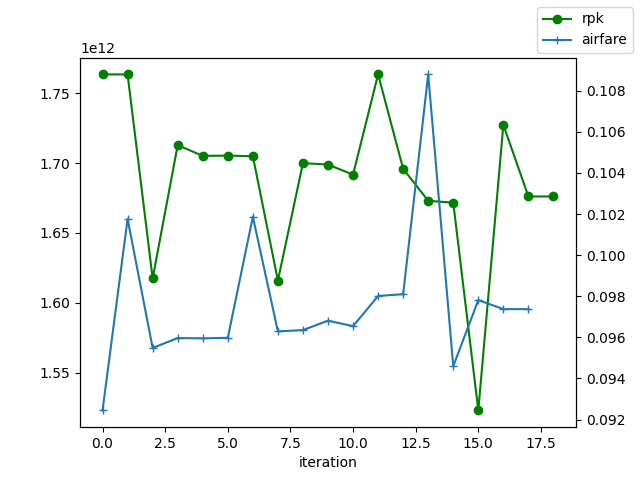

In [44]:
magic_method_view.append(process.vector_outputs_df['airfare_per_rpk_true'].loc[2050])
magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(magic_rpk, marker='o', label='rpk', color='green')
axx=ax.twinx()
axx.plot(magic_method_view, marker='+', label='airfare')

fig.legend()
ax.set_xlabel('iteration')

# 2- Compute

Run AeroMAPS process

In [24]:
# process.compute()

In [25]:
# process.scenario_doe.get_result().optimization_problems_to_results

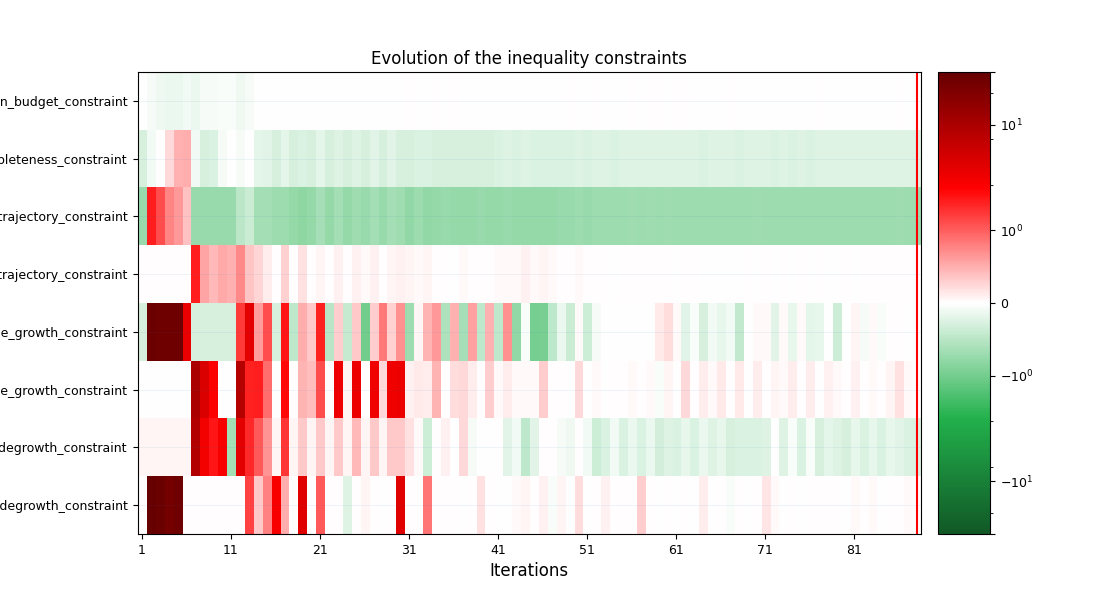

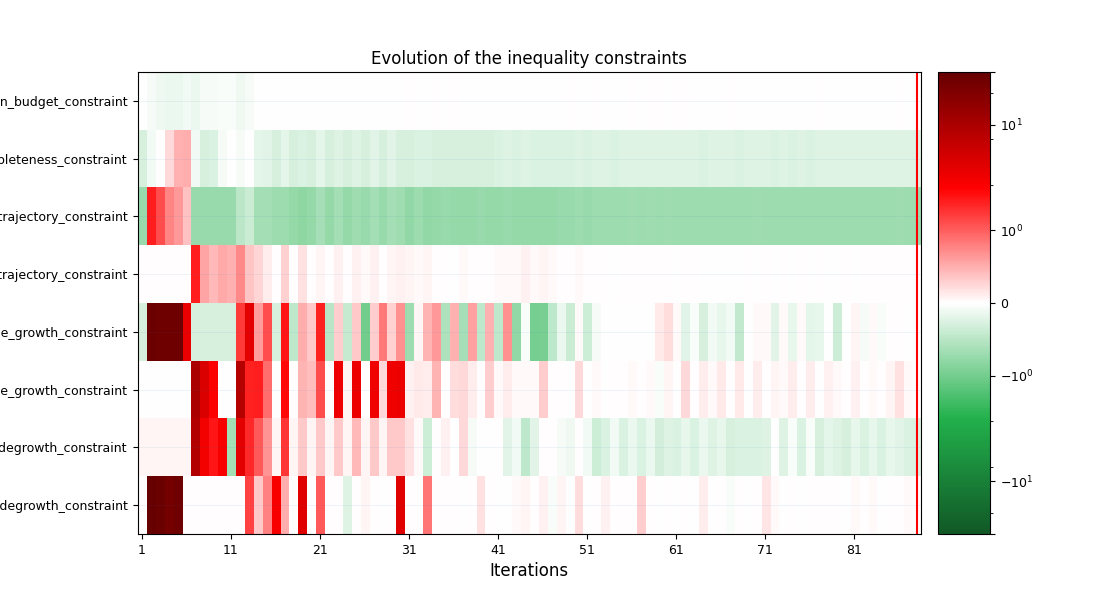

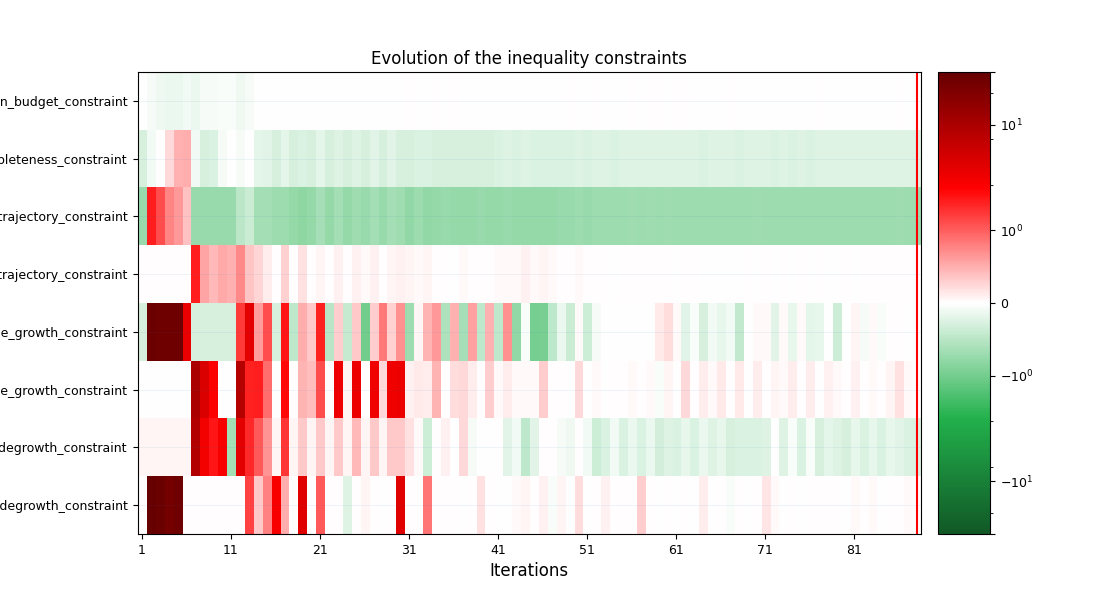

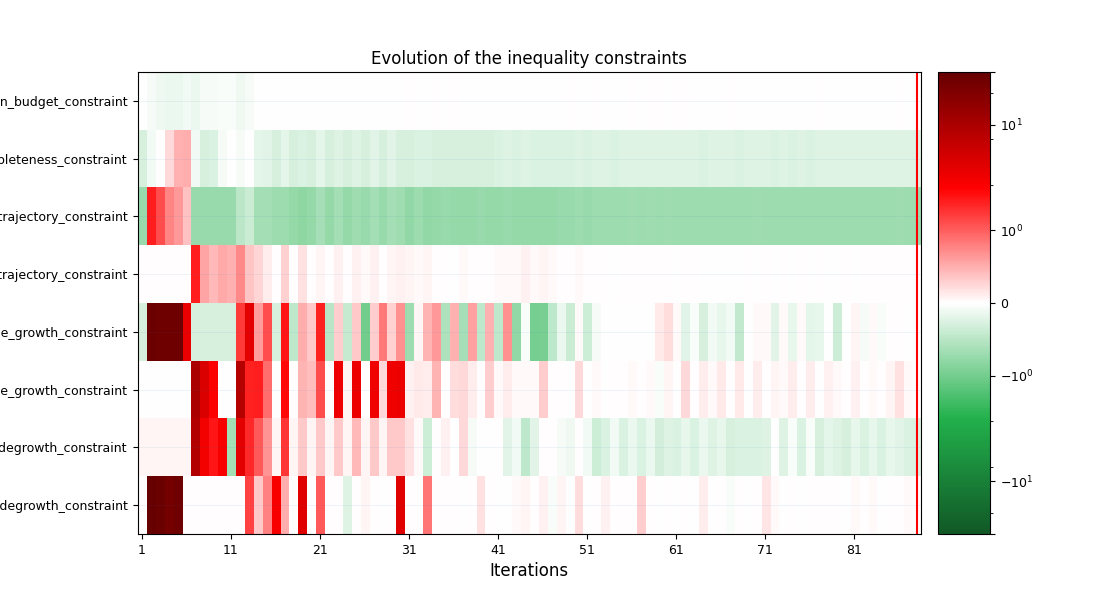

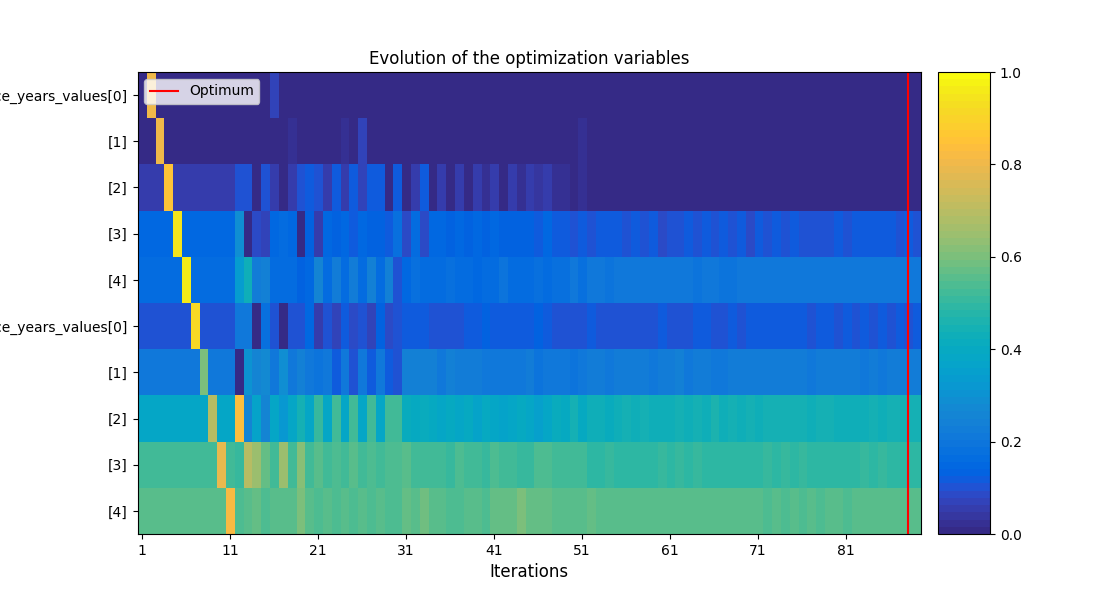

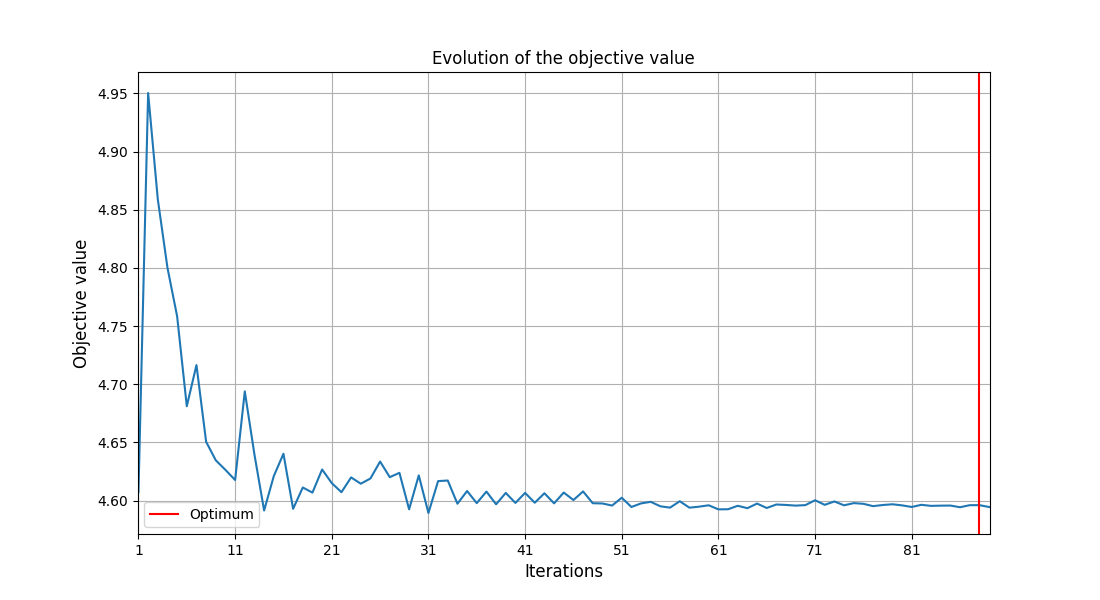

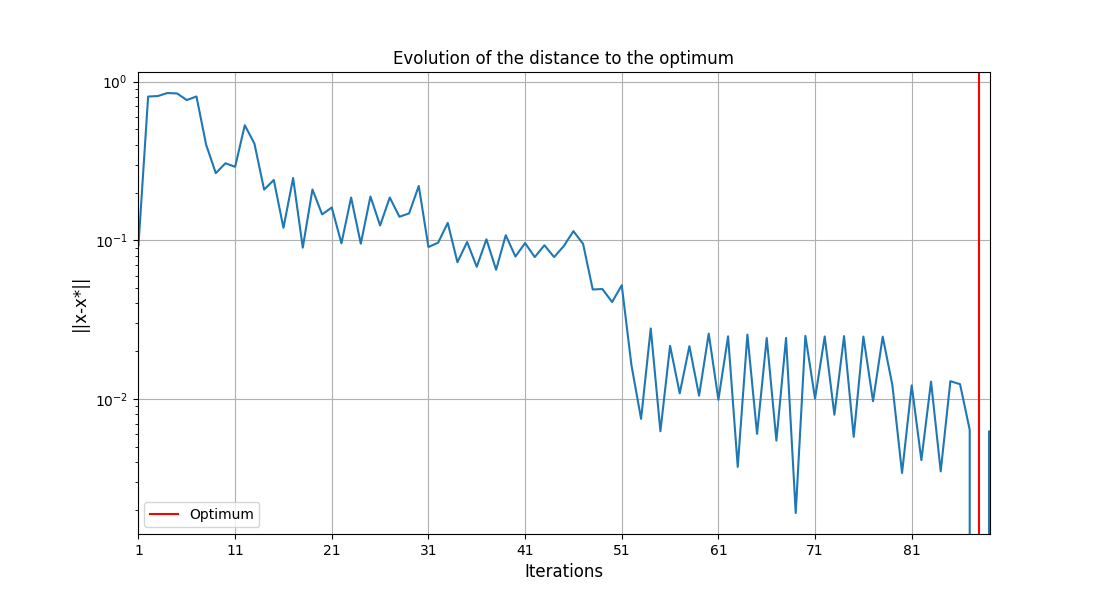

In [26]:
process.scenario.post_process("OptHistoryView", save=False, show=True)

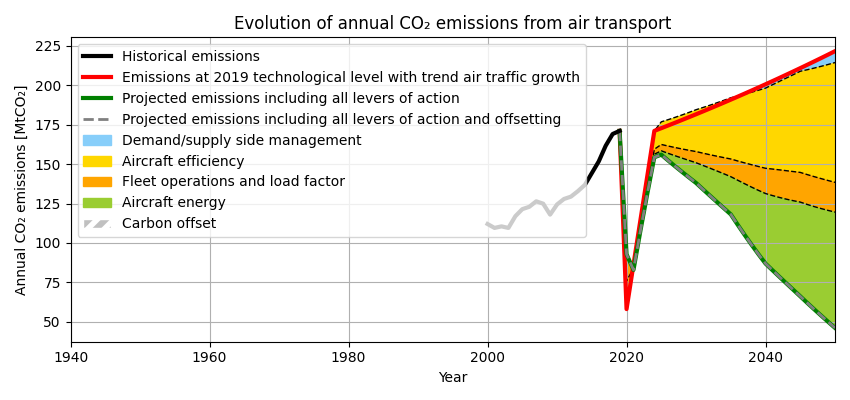

In [27]:
process.plot("air_transport_co2_emissions")

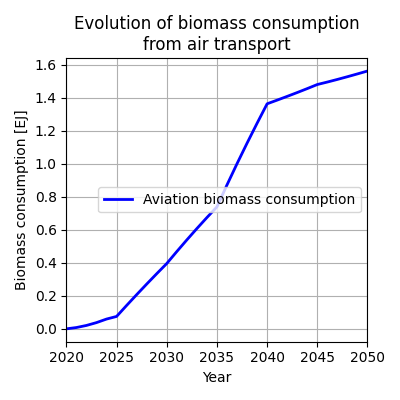

In [28]:
process.plot("biomass_consumption")

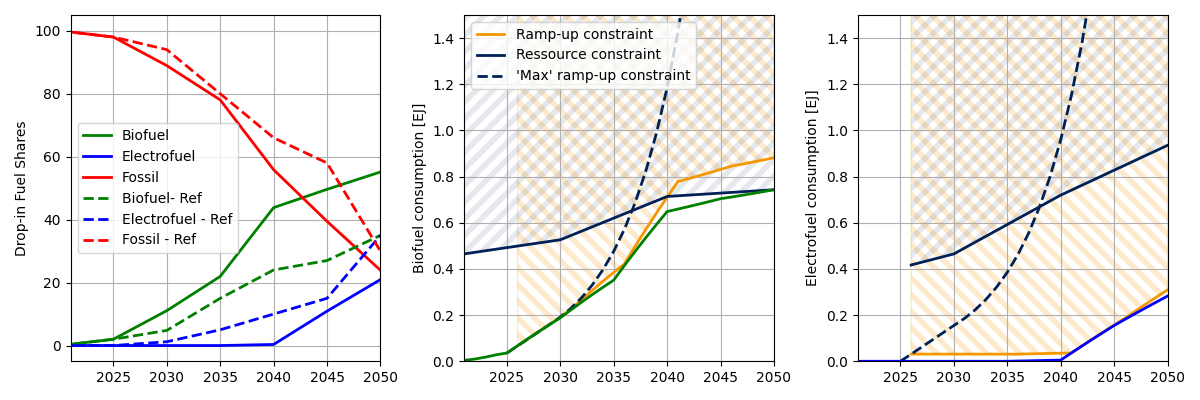

In [29]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(12,4))

ax1.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_share"],
    color="green",
    linestyle="-",
    label="Biofuel",
    linewidth=2,
)

ax1.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_share"],
    color="blue",
    linestyle="-",
    label="Electrofuel",
    linewidth=2,
)

ax1.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "kerosene_share"],
    color="red",
    linestyle="-",
    label="Fossil",
    linewidth=2,
)


ax1.plot(
    [2020,2025,2030,2035,2040,2045,2050],
    [0, 2, 4.8, 15, 24, 27, 35],
    color="green",
    linestyle="--",
    label="Biofuel- Ref",
    linewidth=2,
)

ax1.plot(
    [2020,2025,2030,2035,2040,2045,2050],
    [0, 0, 1.2, 5, 10, 15, 35],
    color="blue",
    linestyle="--",
    label="Electrofuel - Ref",
    linewidth=2,
)

ax1.plot(
    [2020,2025,2030,2035,2040,2045,2050],
    [100, 98, 94.0, 80, 66, 58, 30],
    color="red",
    linestyle="--",
    label="Fossil - Ref",
    linewidth=2,
)


ax1.grid()
ax1.legend()
ax1.set_ylabel("Drop-in Fuel Shares")
ax1.set_xlim(2021,2050)




ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_biofuel_growth_constraint_viz"]/1e12,
    color="#F59700",
    linestyle="-",
    label="Ramp-up constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_biofuel_growth_constraint_viz"]/1e12,
    3,   
    hatch='\\\\',  
    edgecolor="#F59700",
    facecolor='none',
    alpha=0.2
)



ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_max_availability_viz"]/1e12,
    color="#002157",
    linestyle="-",
    label="Ressource constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_max_availability_viz"]/1e12,
    3,   
    hatch='//',  
    edgecolor="#002157",
    facecolor='none',
    linewidth=0,
    alpha=0.1
)


ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "biofuel_growth_constraint_theoretical_max_viz"]/1e12,
    color="#002157",
    linestyle="--",
    label="'Max' ramp-up constraint",
    linewidth=2,
)


ax2.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "energy_consumption_biofuel"]/1e12,
    color="green",
    linestyle="-",
    # label="Aviation biofuel consumption",
    linewidth=2,
)



ax2.grid()
# ax2.set_xlabel("Year")
ax2.set_ylabel("Biofuel consumption [EJ]")
ax2.legend(loc='upper left')
ax2.set_xlim(2021,2050)
ax2.set_ylim(0,1.5)



ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_electrofuel_growth_constraint_viz"]/1e12,
    color="#F59700",
    linestyle="-",
    # label="Electrofuel ramp-up constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "annual_electrofuel_growth_constraint_viz"]/1e12,
    3,   
    hatch='\\\\',  
    edgecolor="#F59700",
    facecolor='none',
    alpha=0.2
)



ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_max_availability_viz"]/1e12,
    color="#002157",
    linestyle="-",
    # label="Electricity availability constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_max_availability_viz"]/1e12,
    3,   
    hatch='//',  
    edgecolor="#002157",
    facecolor='none',
    linewidth=0,
    alpha=0.1
)


ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "electrofuel_growth_constraint_theoretical_max_viz"]/1e12,
    color="#002157",
    linestyle="--",
    # label="Electrofuel theoretical max ramp-Up constraint",
    linewidth=2,
)


ax3.plot(
    process.data['years']['prospective_years'],
    process.vector_outputs_df.loc[process.data['years']['prospective_years'], "energy_consumption_electrofuel"]/1e12,
    color="blue",
    linestyle="-",
    # label="Aviation electrofuel consumption",
    linewidth=2,
)


ax3.grid()
ax3.set_ylabel("Electrofuel consumption [EJ]")
ax3.set_xlim(2021,2050)
ax3.set_ylim(0,1.5)

fig.tight_layout()
fig.savefig('ressource_constraints.png', dpi=800)


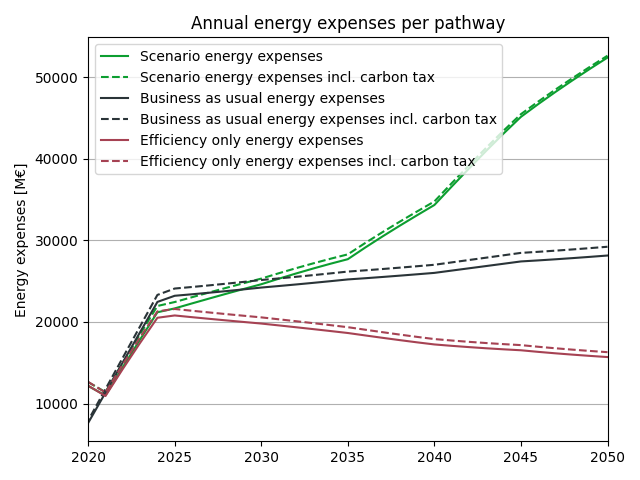

In [30]:
process.plot("energy_expenses_carbon_tax_effect")

In [31]:
process.vector_outputs_df["cumulative_co2_emissions"][2050]

3.218654870756719

In [32]:
process.vector_outputs_df["co2_emissions_including_energy"][2050]


46.22763709434312

In [33]:
process.vector_outputs_df["cumulative_total_airline_cost_discounted"][2050]

4594439690180.773

In [34]:
max(process.vector_outputs_df["electricity_consumption"].dropna())

0.6467136085431082

In [35]:
sum(process.vector_outputs_df["electricity_consumption"].dropna())

3.792281337999473

In [36]:
max(process.vector_outputs_df["biomass_consumption"].dropna())

1.56111318

In [37]:
sum(process.vector_outputs_df["biomass_consumption"].dropna())

24.972869264257966

In [38]:
# from gemseo.algos.design_space import DesignSpace
# from gemseo import generate_n2_plot, create_scenario

# manual_DOE_carbon_budgets = [k * europe_ask_share for k in [2.0, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.2, 3.5, 4.0]]
# manual_DOE_results = {}

                    
# for carbon_budget_share in manual_DOE_carbon_budgets:
    
#     process.parameters.aviation_carbon_budget_objective = carbon_budget_share
                             
#     process.setup()

#     design_space = DesignSpace()

#     # design_space.add_variable("load_factor_end_year", size=1, lower_bound=89.0, upper_bound=89.5, value=89.2)
#     design_space.add_variable("electrofuel_share_reference_years_values", size=7, lower_bound=[0, 0, 0, 0, 0, 0, 0], upper_bound=[0, 100, 100,100, 100, 100, 100], value=[0, 0, 1.2, 5, 10, 15, 35])
#     design_space.add_variable("biofuel_share_reference_years_values", size=7, lower_bound=[0, 0, 0, 0, 0, 0, 0], upper_bound=[0, 100, 100,100, 100, 100, 100], value=[0, 2, 4.8, 15, 24, 27, 35])
#     # design_space.add_variable("biofuel_share_reference_years_values", size=7, lower_bound=np.array([0, 0, 0,0, 0, 0, 0]), upper_bound=np.array([0, 100, 100,100, 100, 100, 100]), value=np.array([0, 0, 1.2, 5, 10, 15, 35]))
#     # design_space.add_variable("biofuel_share_reference_years_values", size=1, lower_bound=1, upper_bound=100, value=5)

#     objective_name = "cumulative_total_airline_cost_discounted_obj"


#     process.gemseo_settings["design_space"] = design_space

#     process.gemseo_settings["objective_name"] = objective_name

#     # process.gemseo_settings["scenario_type"]="DOE"
#     process.gemseo_settings["scenario_type"] = "MDO"

#     # Create a GEMSEO scenario
#     process.create_gemseo_scenario()

#     # Set differention method (only use for gradient based optimizers)
#     process.scenario.set_differentiation_method("finite_differences")

#     # Add constraints
#     all_constraints = [
#         "aviation_carbon_budget_constraint",
#         "blend_completeness_constraint",
#         "electricity_trajectory_constraint",
#         "biomass_trajectory_constraint",
#         "electrofuel_use_growth_constraint",
#         "biofuel_use_growth_constraint",
#         "biofuel_use_no_degrowth_constraint",
#         "electrofuel_use_no_degrowth_constraint"
#     ]



#     for constraint in all_constraints:
#         process.scenario.add_constraint(constraint, constraint_type="ineq")



#     process.scenario.formulation.optimization_problem.objective = process.scenario.formulation.optimization_problem.objective * 1e-12

#     algo_options = {
#         "ftol_rel": 0.001,
#         "ftol_abs": 0.001,
#         "normalize_design_space": True,
#         "init_step":1
#     }
#     # Configure the algorithm used
#     # config_algo = {"algo": "NLOPT_COBYLA", "max_iter": 200}
#     config_algo = {
#         "algo": "NLOPT_COBYLA",
#         "max_iter": 500,
#         "algo_options":algo_options
#     }
#     # config_algo = {"algo": "DIFFERENTIAL_EVOLUTION", "max_iter": 1000}

#     #Configure the DOE used

#     # config_algo = {"algo": "LHS", "n_samples": 1000}


#     process.input_data.update(config_algo)
                             
#     process.compute()
    
#     manual_DOE_results[carbon_budget_share]=process.scenario.get_result().optimization_problems_to_results
                             
    

In [39]:
# manual_DOE_results

In [40]:
# {
#   "0.3098": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 0.0200054873, 2.05140066, 21.1813998, 50.2237717, 62.708779, 67.6659455, 0.0, 6.37460003, 13.3005508, 23.9880299, 34.5420461, 38.6414905, 40.5526613],
#         "Objective function": 4.923723348357994,
#         "Feasible solution": false
#       }
#     }
#   },
#   "0.38725000000000004": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 9.50830997e-16, 5.46074505e-15, 4.87835124, 17.8344375, 35.9188935, 44.7192748, 0.0, 6.06082219, 13.16114, 23.2813313, 30.8878381, 35.5180169, 37.1535953],
#         "Objective function": 4.703385363758759,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.40274000000000004": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 5.68528514e-16, 3.52478468e-16, 2.13553207, 11.523514, 27.3651544, 48.9386831, 0.0, 5.57028651, 13.8559199, 14.8875224, 26.9343106, 35.2600772, 37.1299377],
#         "Objective function": 4.65427847765963,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.41823000000000005": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 8.00602614e-15, 0.493206033, 2.15320295, 6.84688915, 16.065036, 35.8409102, 0.0, 5.21639236, 9.54168243, 15.385152, 30.3210818, 35.4914538, 36.6780568],
#         "Objective function": 4.608114408167807,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.43372": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 2.60208521e-15, 2.01227923e-14, 1.90819582e-14, 4.46973153, 14.5540439, 32.7356765, 0.0, 3.12017252, 8.47822827, 13.5795412, 23.1990379, 29.6078295, 34.8518127],
#         "Objective function": 4.569699143108438,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.44921": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 0.11924028, 0.4731823, 3.9455404, 17.04417396, 40.53708351, 56.24505107, 0.0, 0.08376552, 0.67126784, 8.39397436, 15.21908486, 28.46091729, 36.36557437],
#         "Objective function": 4.659503862073434,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.4647": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 5.0497717e-16, 1.71911138e-15, 7.20866319e-15, 5.34337113e-14, 2.77555756e-14, 1.61869054, 0.0, 9.96287534e-15, 2.65478792, 10.1524168, 20.8683498, 32.3839377, 37.0775387],
#         "Objective function": 4.4858105558686425,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.49568000000000006": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 1.209974e-15, 9.07712291e-17, 4.52762243e-17, 0.501961593, 13.5764353, 29.1746387, 0.0, 1.50004538, 10.175401, 20.0427433, 27.2900464, 35.5768404, 37.155043],
#         "Objective function": 4.570591342503452,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.54215": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 1.63064007e-14, 1.83880688e-14, 1.11022302e-14, 6.1409211e-14, 8.46564825, 53.1968294, 0.0, 8.32667268e-15, 6.28789295, 12.7622453, 20.8460642, 30.18929, 31.6952819],
#         "Objective function": 4.555169656402445,
#         "Feasible solution": true
#       }
#     }
#   },
#   "0.6196": {
#     "main": {
#       "Optimization result": {
#         "Design variables": [0.0, 1.63064007e-14, 1.83880688e-14, 1.11022302e-14, 6.1409211e-14, 8.46564825, 53.1968294, 0.0, 8.32667268e-15, 6.28789295, 12.7622453, 20.8460642, 30.18929, 31.6952819],
#         "Objective function": 4.555169656402445,
#         "Feasible solution": true
#       }
#     }
#   }
# }
